In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import keras
from keras.optimizers import Adam
from keras.layers import GRU, Dense, Dropout, BatchNormalization, Activation
from keras.models import Model, Sequential
from keras.regularizers import l1_l2
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler, Normalizer, PowerTransformer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.ensemble import IsolationForest
import tensorflow as tf
from sklearn.preprocessing import PowerTransformer
from keras.regularizers import l1_l2

import warnings
warnings.filterwarnings("ignore")

np.random.seed(42)

2024-06-12 19:28:01.985197: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-12 19:28:02.656649: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
volatility_df = pd.read_csv('volatility_df.csv', 
                     parse_dates=['Date'], index_col='Date')

In [3]:
volatility_df = volatility_df[['Recovered_vol', 'Realized_Volatility']]

volatility_df = volatility_df.replace([0], 1e-6)

volatility_df = volatility_df / volatility_df.shift(1) - 1

lag = -5
volatility_df[f'Realized_Volatility_(t+{abs(lag)})'] = volatility_df['Realized_Volatility'].shift(lag)
volatility_df = volatility_df.dropna()
volatility_df.drop('Realized_Volatility', axis=1, inplace=True)
print(len(volatility_df))
volatility_df.head(10)

3357


,Recovered_vol,Realized_Volatility_(t+5)
Date,,
2010-01-05,-0.024188,0.031692
2010-01-06,0.001425,0.029962
2010-01-07,0.007015,-0.022161
2010-01-08,0.030061,0.046408
2010-01-11,0.030583,0.073188
2010-01-12,-0.037054,-0.011969
2010-01-13,0.161288,0.137014
2010-01-14,0.012751,0.125819
2010-01-15,-0.231002,0.002256


In [4]:
# Стандартизация, нормализация, замена выбросов медианой

values_clear = volatility_df.copy()

train_size = int(len(values_clear) * 0.7)
val_size = int(len(values_clear) * 0.15)
test_size = len(values_clear) - train_size - val_size

train = values_clear.iloc[:train_size]
val = values_clear.iloc[train_size:train_size + val_size]
test = values_clear.iloc[train_size + val_size:]

# Обучаем стандартизатор, нормализатор и изолейшн форест на тренировочных данных
transformer = PowerTransformer(method='yeo-johnson')
transformer.fit(train)
train_transformed = transformer.transform(train)

scaler = MinMaxScaler(feature_range=(1e-6, 1))
scaler.fit(train_transformed)
train_scaled = scaler.transform(train_transformed)

isolation_forest = IsolationForest(n_estimators=1000, contamination=0.01, random_state=42) # 0.01
isolation_forest.fit(train_scaled)

normalizer = Normalizer()
normalizer.fit(train_scaled)

# Применяем стандартизатор, нормализатор и изолейшн форест на тренировочных, валидационных и тестовых данных
train_isolation_forest = isolation_forest.predict(train_scaled)
train_normalized = normalizer.transform(train_scaled)

val_transformed = transformer.transform(val)
val_scaled = scaler.transform(val_transformed)
val_isolation_forest = isolation_forest.predict(val_scaled)
val_normalized = normalizer.transform(val_scaled)

test_transformed = transformer.transform(test)
test_scaled = scaler.transform(test_transformed)
test_isolation_forest = isolation_forest.predict(test_scaled)
test_normalized = normalizer.transform(test_scaled)

# Считаем метрику
train_values = np.median(train_normalized, axis=0)
val_values = np.median(val_normalized, axis=0)
test_values = np.median(test_normalized, axis=0)

# Заполняем выбросы медианой
train_normalized[train_isolation_forest == -1] = train_values
val_normalized[val_isolation_forest == -1] = val_values
test_normalized[test_isolation_forest == -1] = test_values

y_train = train_normalized[:, -1:]
y_train = np.squeeze(y_train)
X_train = np.delete(train_normalized, -1, axis=1)

y_val = val_normalized[:, -1:]
y_val = np.squeeze(y_val)
X_val = np.delete(val_normalized, -1, axis=1)

y_test = test_normalized[:, -1:]
y_test = np.squeeze(y_test)
X_test = np.delete(test_normalized, -1, axis=1)

# Reshape
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)

(2349, 1, 1) (2349,) (503, 1, 1) (503,) (505, 1, 1) (505,)


In [5]:
# GRU

In [6]:
# custom_logcosh

penalty = 5
quantile_threshold = 75
quantile = tf.constant(np.percentile(y_train, quantile_threshold), dtype=tf.float32)

def custom_logcosh(y_true, y_pred):
    error = y_true - y_pred
    mask = tf.cast(y_true > quantile, tf.float32)
    weighted_error = error * (1 + penalty * mask * (y_true - quantile))
    return tf.reduce_sum(tf.math.log(tf.math.cosh(weighted_error)))

In [7]:
n_units = 4
dropout_rate = 0.0
recurrent_dropout_rate = 0.0
activation = 'tanh'
seed = 1
input_model = (X_train.shape[1], X_train.shape[2])

model = Sequential()

model.add(GRU(
    n_units,
    activation=activation, 
    return_sequences=True,
    input_shape=input_model,
    recurrent_dropout=recurrent_dropout_rate,
    seed=seed,
))
model.add(Dropout(dropout_rate))

model.add(GRU(
    n_units,
    activation=activation,
    return_sequences=True,
    recurrent_dropout=recurrent_dropout_rate,
    seed=seed
))
model.add(Dropout(dropout_rate))

model.add(GRU(
    n_units,
    activation=activation,
    recurrent_dropout=recurrent_dropout_rate,
    seed=seed
))
model.add(Dropout(dropout_rate))

model.add(Dense(1))
model.add(Activation('linear'))

early_stopping = EarlyStopping(monitor='val_loss', patience=5)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss=custom_logcosh) # keras.losses.log_cosh

history = model.fit(X_train,
                    y_train,
                    epochs=500,
                    batch_size=4,
                    validation_data=(X_val, y_val),
                    verbose=1,
                    shuffle=False,
                    callbacks=[early_stopping])

# Предсказание значений на валидационной выборке
val_pred = model.predict(X_val)
print(f'MSE val: {mean_squared_error(y_val, val_pred):.4f}')
print(f'MAE val: {mean_absolute_error(y_val, val_pred):.4f}')
print(f'R2 val: {r2_score(y_val, val_pred):.4f}')
print(f'MAPE val: {mean_absolute_percentage_error(y_val, val_pred):.4f}')

# Предсказание значений на тестовой выборке
y_pred = model.predict(X_test)
print(f'MSE test: {mean_squared_error(y_test, y_pred):.4f}')
print(f'MAE test: {mean_absolute_error(y_test, y_pred):.4f}')
print(f'R2 test: {r2_score(y_test, y_pred):.4f}')
print(f'MAPE test: {mean_absolute_percentage_error(y_test, y_pred):.4f}')

Epoch 1/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.8945 - val_loss: 0.4647
Epoch 2/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3173 - val_loss: 0.0253
Epoch 3/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0149 - val_loss: 0.0060
Epoch 4/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0070 - val_loss: 0.0059
Epoch 5/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0070 - val_loss: 0.0059
Epoch 6/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0069 - val_loss: 0.0058
Epoch 7/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0069 - val_loss: 0.0058
Epoch 8/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0068 - val_loss: 0.0057
Epoch 9/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0067 - val_loss: 0.0056
Epoch 10/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0066 - val_loss: 0.0055
Epoch 11/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0065 - val_loss: 0.0054
Epoch 12/500
588/588 ━━━━━━━━━━━━━━━━━━━━

588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 8.2189e-05 - val_loss: 9.8984e-05
Epoch 68/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 8.1663e-05 - val_loss: 9.8533e-05
Epoch 69/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 8.1157e-05 - val_loss: 9.8119e-05
Epoch 70/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 8.0654e-05 - val_loss: 9.7711e-05
Epoch 71/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 8.0139e-05 - val_loss: 9.7328e-05
Epoch 72/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7.9636e-05 - val_loss: 9.6938e-05
Epoch 73/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7.9123e-05 - val_loss: 9.6529e-05
Epoch 74/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7.8617e-05 - val_loss: 9.6149e-05
Epoch 75/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7.8104e-05 - val_loss: 9.5766e-05
Epoch 76/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7.7593e-05 - val_loss: 9.5372e-05
Epoch 77/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Epoch 130/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.7665e-05 - val_loss: 6.8636e-05
Epoch 131/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.7091e-05 - val_loss: 6.7961e-05
Epoch 132/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.6504e-05 - val_loss: 6.7307e-05
Epoch 133/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.5932e-05 - val_loss: 6.6611e-05
Epoch 134/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.5347e-05 - val_loss: 6.5899e-05
Epoch 135/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.4760e-05 - val_loss: 6.5161e-05
Epoch 136/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.4170e-05 - val_loss: 6.4408e-05
Epoch 137/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.3585e-05 - val_loss: 6.3661e-05
Epoch 138/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.2991e-05 - val_loss: 6.2847e-05
Epoch 139/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.2402e-05 - val_loss: 6.2059e-05
Epoch 140/500
588/588 ━━━━━━━━

588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.0103e-05 - val_loss: 5.6379e-06
Epoch 193/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 9.6603e-06 - val_loss: 5.0058e-06
Epoch 194/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 9.2328e-06 - val_loss: 4.4420e-06
Epoch 195/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 8.8236e-06 - val_loss: 3.9384e-06
Epoch 196/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 8.4269e-06 - val_loss: 3.4618e-06
Epoch 197/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 8.0416e-06 - val_loss: 2.9994e-06
Epoch 198/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7.6758e-06 - val_loss: 2.6958e-06
Epoch 199/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7.3348e-06 - val_loss: 2.3593e-06
Epoch 200/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7.0139e-06 - val_loss: 2.2614e-06
Epoch 201/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6.7002e-06 - val_loss: 2.2676e-06
Epoch 202/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1

In [8]:
# # сохранение модели с помощью метода save()

# # GRU_model_v1.keras - 1 признак Recovered_vol
# model_filename = '/home/ranksjupyter/notebooks/Ranks/sector_models/vols_pred/gru_model_v1.keras'
# model.save(model_filename)

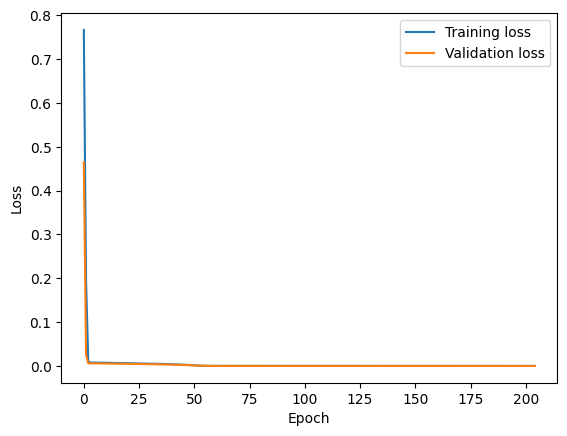

In [9]:
# График лосса

train_loss = history.history['loss']
val_loss = history.history['val_loss']

fig, ax = plt.subplots()
ax.plot(train_loss, label='Training loss')
ax.plot(val_loss, label='Validation loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()
plt.show()

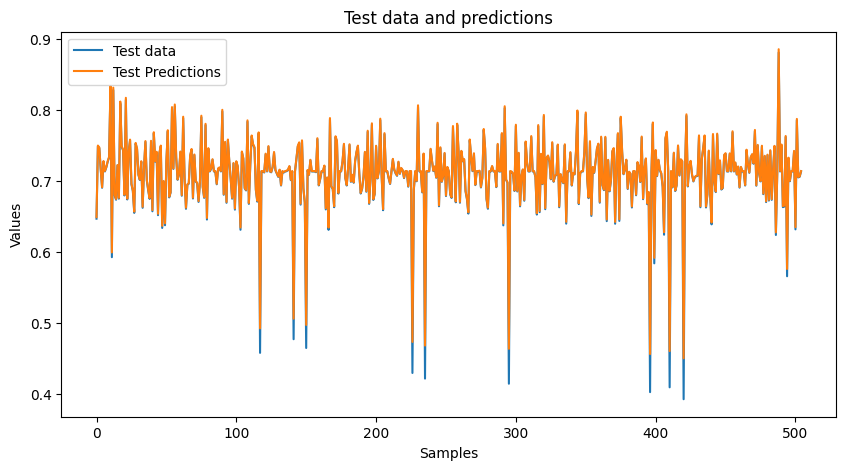

In [10]:
# Построение графика тестовой выборки и прогнозов

plt.figure(figsize=(10, 5))
plt.plot(y_test, label='Test data')
plt.plot(y_pred, label='Test Predictions')
plt.title('Test data and predictions')
plt.xlabel('Samples')
plt.ylabel('Values') 
plt.legend()
plt.show()

In [11]:
# keras.losses.log_cosh

n_units = 4
dropout_rate = 0.0
recurrent_dropout_rate = 0.0
activation = 'tanh'
seed = 1
input_model = (X_train.shape[1], X_train.shape[2])

model = Sequential()

model.add(GRU(
    n_units,
    activation=activation, 
    return_sequences=True,
    input_shape=input_model,
    recurrent_dropout=recurrent_dropout_rate,
    seed=seed,
))
model.add(Dropout(dropout_rate))

model.add(GRU(
    n_units,
    activation=activation,
    return_sequences=True,
    recurrent_dropout=recurrent_dropout_rate,
    seed=seed
))
model.add(Dropout(dropout_rate))

model.add(GRU(
    n_units,
    activation=activation,
    recurrent_dropout=recurrent_dropout_rate,
    seed=seed
))
model.add(Dropout(dropout_rate))

model.add(Dense(1))
model.add(Activation('linear'))

early_stopping = EarlyStopping(monitor='val_loss', patience=5)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss=keras.losses.log_cosh) # keras.losses.log_cosh

history = model.fit(X_train,
                    y_train,
                    epochs=500,
                    batch_size=4,
                    validation_data=(X_val, y_val),
                    verbose=1,
                    shuffle=False,
                    callbacks=[early_stopping])

# Предсказание значений на валидационной выборке
val_pred_log_cosh = model.predict(X_val)
print(f'MSE val: {mean_squared_error(y_val, val_pred_log_cosh):.4f}')
print(f'MAE val: {mean_absolute_error(y_val, val_pred_log_cosh):.4f}')
print(f'R2 val: {r2_score(y_val, val_pred):.4f}')
print(f'MAPE val: {mean_absolute_percentage_error(y_val, val_pred):.4f}')

# Предсказание значений на тестовой выборке
y_pred_log_cosh = model.predict(X_test)
print(f'MSE test: {mean_squared_error(y_test, y_pred_log_cosh):.4f}')
print(f'MAE test: {mean_absolute_error(y_test, y_pred_log_cosh):.4f}')
print(f'R2 test: {r2_score(y_test, y_pred_log_cosh):.4f}')
print(f'MAPE test: {mean_absolute_percentage_error(y_test, y_pred_log_cosh):.4f}')

Epoch 1/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.1750 - val_loss: 0.0449
Epoch 2/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0229 - val_loss: 0.0014
Epoch 3/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 4/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 5/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 6/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 7/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 8/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 9/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 10/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 11/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 12/500
588/588 ━━━━━━━━━━━━━━━━━━━━

588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.4908e-05 - val_loss: 1.5097e-05
Epoch 66/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.4821e-05 - val_loss: 1.4946e-05
Epoch 67/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.4733e-05 - val_loss: 1.4807e-05
Epoch 68/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.4646e-05 - val_loss: 1.4675e-05
Epoch 69/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.4558e-05 - val_loss: 1.4542e-05
Epoch 70/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.4472e-05 - val_loss: 1.4410e-05
Epoch 71/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.4385e-05 - val_loss: 1.4284e-05
Epoch 72/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.4299e-05 - val_loss: 1.4157e-05
Epoch 73/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.4214e-05 - val_loss: 1.4030e-05
Epoch 74/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.4132e-05 - val_loss: 1.3905e-05
Epoch 75/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Epoch 128/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.0152e-05 - val_loss: 8.2801e-06
Epoch 129/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.0087e-05 - val_loss: 8.1927e-06
Epoch 130/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.0022e-05 - val_loss: 8.1055e-06
Epoch 131/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 9.9561e-06 - val_loss: 8.0188e-06
Epoch 132/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 9.8907e-06 - val_loss: 7.9318e-06
Epoch 133/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 9.8269e-06 - val_loss: 7.8487e-06
Epoch 134/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 9.7614e-06 - val_loss: 7.7616e-06
Epoch 135/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 9.6982e-06 - val_loss: 7.6781e-06
Epoch 136/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 9.6333e-06 - val_loss: 7.5956e-06
Epoch 137/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 9.5709e-06 - val_loss: 7.5094e-06
Epoch 138/500
588/588 ━━━━━━━━

588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6.4365e-06 - val_loss: 3.6809e-06
Epoch 191/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6.3814e-06 - val_loss: 3.6281e-06
Epoch 192/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6.3275e-06 - val_loss: 3.5648e-06
Epoch 193/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6.2720e-06 - val_loss: 3.5126e-06
Epoch 194/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6.2185e-06 - val_loss: 3.4540e-06
Epoch 195/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6.1619e-06 - val_loss: 3.3972e-06
Epoch 196/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6.1084e-06 - val_loss: 3.3422e-06
Epoch 197/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6.0536e-06 - val_loss: 3.2847e-06
Epoch 198/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6.0002e-06 - val_loss: 3.2316e-06
Epoch 199/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.9460e-06 - val_loss: 3.1782e-06
Epoch 200/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1

588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.3290e-06 - val_loss: 1.4063e-06
Epoch 253/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.2867e-06 - val_loss: 1.4163e-06
Epoch 254/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.2445e-06 - val_loss: 1.4235e-06
Epoch 255/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.2015e-06 - val_loss: 1.4325e-06
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
MSE val: 0.0000
MAE val: 0.0009
R2 val: 0.9989
MAPE val: 0.0016
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step
MSE test: 0.0001
MAE test: 0.0017
R2 test: 0.9799
MAPE test: 0.0033


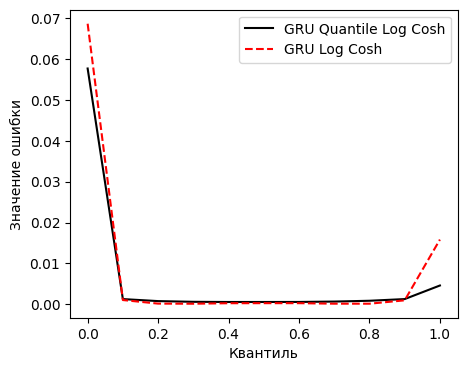

In [12]:
# GRU quantile logcosh
quan = []
for q in np.arange(0, 1.1, 0.1):
    quantile_error = np.abs(np.quantile(y_test, q) - np.quantile(y_pred, q))
    quan.append(quantile_error)
quan_df = pd.DataFrame(quan, columns=['GRU quantile logcosh'])
index = np.arange(0, len(quan_df)*0.1, 0.1)
quan_df.set_index(index, inplace=True)

# GRU logcosh
quan_log_cosh = []
for q in np.arange(0, 1.1, 0.1):
    quantile_error = np.abs(np.quantile(y_test, q) - np.quantile(y_pred_log_cosh, q))
    quan_log_cosh.append(quantile_error)
    
quan_df_log_cosh = pd.DataFrame(quan_log_cosh, columns=['GRU logcosh'])
index = np.arange(0, len(quan_df_log_cosh)*0.1, 0.1)
quan_df_log_cosh.set_index(index, inplace=True)

quan_df['GRU logcosh'] = quan_df_log_cosh

plt.figure(figsize=(5, 4))
plt.plot(quan_df['GRU quantile logcosh'], color='black', label='GRU Quantile Log Cosh')
plt.plot(quan_df['GRU logcosh'], color='red', label='GRU Log Cosh', linestyle='--')
plt.legend()
plt.xlabel('Квантиль')
plt.ylabel('Значение ошибки')

plt.savefig('gru_q_errors.svg', format='svg')

plt.show()